In [10]:
using JuMP, PyPlot, Ipopt

# Solution 1: Hexagon Construction
The goal is to figure out the optimal geometry of a hexagon such that (1) the hexagon’s area is maximized and (2) the hexagon’s diameter does not exceed 1. The diameter of the hexagon is the largest distance between any pair of points belonging to the hexagon. There are many different ways to solve this problem.

In [11]:
# Since we have to construct a hexagon and so the value of n will be 6
n = 6

# m = Model(solver = IpoptSolver())
m = Model(solver=IpoptSolver(print_level=0))

# For hexagon we will have 6 coordinates for each vertices
@variable(m, x[1:n])
@variable(m, y[1:n])

# As per the hint given, Placing one of the vertices at the origin
@constraint(m, x[1] == 0)
@constraint(m, y[1] == 0)

# goal is to figure out the optimal geometry of a hexagon such that (1) the hexagon’s area is maximized
@NLobjective(m, Max, 0.5*sum( x[i]*y[i+1]-y[i]*x[i+1] for i=1:n-1))

# The diameter of the hexagon is the largest distance between any pair of points belonging to the hexagon.
# For each pair of vertices, the distance between any pair of vertices <= 1
for i in 1:6
    for j in 1:6
        @constraint(m, ((x[i] - x[j])^2 + (y[i] - y[j])^2) <= 1)
    end
end          

# add ordering constraint to the vertices
for i = 1:n-1
    @NLconstraint(m, x[i]*y[i+1]-y[i]*x[i+1] >= 0 )
end
# @NLconstraint(m, x[n]*y[1]-y[n]*x[1] >= 0 )

srand(0)
setvalue(x,rand(n))
setvalue(y,rand(n))            

status = solve(m)
println(status)
println("Optimal area: ", getobjectivevalue(m))
getvalue([x y])

Optimal
Optimal area: 0.6749814196090831


6×2 Array{Float64,2}:
 -1.64316e-26  -1.09255e-35
  0.50027       0.402015   
  0.344402      0.938822   
  0.000671822   1.0        
 -0.343141      0.939284   
 -0.49973       0.402686   

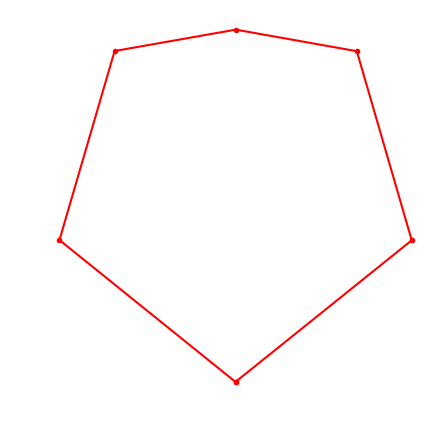

In [12]:
using PyPlot
xopt = getvalue([x; x[1]])
yopt = getvalue([y; y[1]])
t = linspace(0,2π,100)
figure(figsize=[5,5])
# plot( cos(t), sin(t), "b-" )
plot( xopt, yopt, "r.-" )
axis("equal");axis("off");

In [13]:
println("Optimal area: ", getobjectivevalue(m))

Optimal area: 0.6749814196090831


# Solution 2: Fertilizer influence model
A series of experiments is conducted to determine the effect of a particular fertilizer on wheat crop yield. Here are the results:

|fertilizer rate (x) |crop yield (y)
|--------------|
|-5  |127
|-3  |151
|-1  |379
|1   |421
|3   |460
|5   |426

Such situations typically involve some sort of “diminishing returns”. So there is a limit to how much the fertilizer can boost the yield. A popular model for this relationship is the following:
\begin{equation*}
y = k_1 + k_2exp(k_3x)
\end{equation*}
Use nonlinear least squares to determine the values of (k1, k2, k3) that provide the best fit to the data. We are expecting coefficients in the neighborhood of (500, −200, −1).

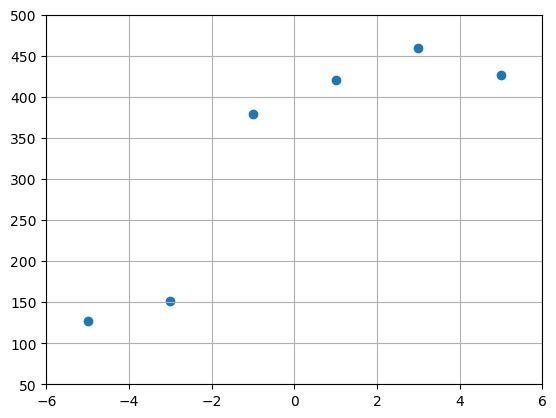

In [14]:
x = [-5, -3, -1, 1, 3, 5]
y = [127, 151, 379, 421, 460, 426]

using PyPlot
# figure(figsize=(12,4))
scatter(x, y)
# plot(x,y,"r.", markersize=4)
xlim([-6,6]); ylim([50,500])
grid("on")

In [18]:
# m1 = Model(solver = IpoptSolver())
m1 = Model(solver=IpoptSolver(print_level=0))
@variable(m1, k[1:3])

# variable to determine predicted values for all six points from the input
@variable(m1, p[1:6])

#set regression values
for i in 1:6
    @NLconstraint(m1, p[i] == k[1] + (k[2]*exp(x[i]k[3])))
end

# Use nonlinear least squares to determine the values of (k1, k2, k3) that provide the best fit to the data. 
@NLobjective(m1, Min, sum((p[i] - y[i])^2 for i in 1:6))
solve(m1)
println("Objective: ", getobjectivevalue(m1))

Objective: 13390.09311947958


In [16]:
kopt = getvalue(k)
for i in 1:3
    println("Value of k", i, ":  ", kopt[i])
end

Value of k1:  523.3055386212442
Value of k2:  -156.94784350151681
Value of k3:  -0.19966456906074553


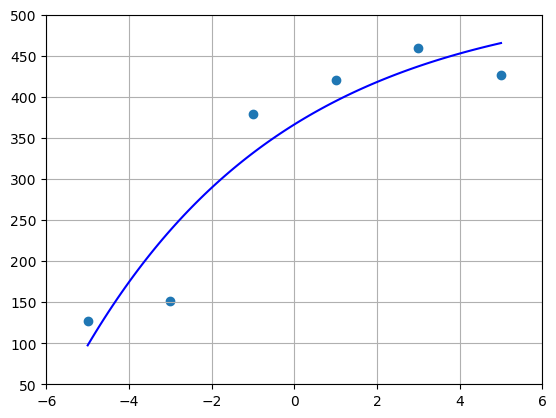

In [17]:
x_pred = linspace(-5, 5, 100)
y_pred = kopt[1] + kopt[2].*exp(kopt[3].*x_pred)

# figure(figsize=(12,4))
scatter(x, y)
# plot(x,y,"r.", markersize=4)
plot(x_pred, y_pred, "b", markersize=4)
xlim([-6,6]); ylim([50,500])
grid("on")